## In-class hands-on activity: Regularization and Optimization

### Breast Cancer Diagnostic Dataset
Original dataset from <https://www.kaggle.com/code/rcfreitas/python-ml-breast-cancer-diagnostic-data-set>

走過下面的的Cell, 依序執行。下面有些Cell中標明"TODO"。請依照說明完成這些函數或程式片段，讓整個檔案能正確的執行。

課程名稱: 統計學習與深度學習。

Note: You do not need a GPU to run the script. (But it will take a bit longer to run without a GPU.)

# Outline

* Setup wandb
* MLP examples with different learning rate.* 
* MLP examples considering dropout.


### Note
This example partition a dataset into training and validation sets. No test set is considered. 
While the validation performance is usually close to test performance, there is no guarntee that this is always the case.
This demo is only for pedagogical purpose and is not intended to serve as the template of an "official" project. 

You should evaluate model performance using a separate test set if you are interested in the generalization performance.  

# Setup wandb (Weights & Biases)

The wandb website <https://wandb.ai/site/> is a popular tool to track AI project training and evaluation status. Most functions are free. We will leveragewandb in subsequent discussion. 

* <b>Step 1</b>: You will need to signup first before going forward (the upper right corner of <https://wandb.ai/site/>). Consider using github/Google/Microsoft account to login if you are willing to share info across sites.
* <b> Step 2</b>: Setup local wandb library using pip. Sample cmd: `!pip install wandb`
* <b> Step 3</b>: Navigate to the Authorize page <https://wandb.ai/authorize> to create an API key, and save it for later use.



In [32]:
# !pip install wandb

In [33]:
import wandb

### Login with your API Key

In [34]:
# TODO: register on wandb and fill in your own api key
wandb.login(key="71c4069cf744aed16b5098e82b65fed5b3ba7f17")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/jiangyanhong/.netrc
wandb: Appending key for api.wandb.ai to your netrc file: /Users/jiangyanhong/.netrc


True

### Initialize this project setting

Initialize project setting with code look likes this:

```python
run = wandb.init(
    # Set the project where this run will be logged
    project="sldl_23_regu_opt",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": 0.01,
        "epochs": 10,
    },
)
```

We will do this later after the data and model has been setup.

# MLP Example using Breast Cancer Dataset

We demonstrate the process of constructing Multiple Layer Perception (MLP) for classification here. 

The dataset is from UCI Machine Learning Repository <https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29>

We use the csv format from <https://www.kaggle.com/uciml/breast-cancer-wisconsin-data?select=data.csv>

# Data Columns

```
1) ID number
2) Diagnosis (M = malignant, B = benign)
3-32)
Ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter)
b) texture (standard deviation of gray-scale values)
c) perimeter
d) area
e) smoothness (local variation in radius lengths)
f) compactness (perimeter^2 / area - 1.0)
g) concavity (severity of concave portions of the contour)
h) concave points (number of concave portions of the contour)
i) symmetry
j) fractal dimension ("coastline approximation" - 1)
```

# Data Preparations

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('breast_cancer.csv')
print("\n \t The data frame has {0[0]} rows and {0[1]} columns. \n".format(data.shape))
# data.info()


 	 The data frame has 569 rows and 33 columns. 



In [36]:
data.head(3)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN


### Drop Unwanted Columns
The first column (id) and the last column (Unnamed) are are needed. 

In [37]:
data.drop(data.columns[[-1, 0]], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

# Number of Malignant and Benign Cases

In [38]:
diagnosis_all = list(data.shape)[0]
diagnosis_categories = list(data['diagnosis'].value_counts())

print("The data has {} diagnosis, {} benign and {} malignant."
      .format(diagnosis_all, diagnosis_categories[0], diagnosis_categories[1]))

The data has 569 diagnosis, 357 benign and 212 malignant.


# Transform Label Values and Split Training and Test Sets
* M --> 1
* B --> 0

In [39]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

features_name = list(data.columns[1:11]) 
diag_map = {'M':1, 'B':0}
data['diagnosis'] = data['diagnosis'].map(diag_map)
X = data.loc[:,features_name]
y = data.loc[:, 'diagnosis']
# make sure we are using float32 datatype
X = X.astype('float32')
y = y.astype('float32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Baseline: Random Foreast Classifier

In [40]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 500)
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
accuracy_rf  = accuracy_score(prediction, y_test)
print("Random Forest Accuracy: {0:.2%}".format(accuracy_rf))

Random Forest Accuracy: 94.74%


# Standardize Feature Values

In [41]:
from sklearn import preprocessing
xscaler = preprocessing.StandardScaler().fit(X_train)
#standardize feature values
X_trainstd = xscaler.transform(X_train)
X_teststd = xscaler.transform(X_test)

In [42]:
#Just to verify feature standardization
print("Column means:")
np.mean(X_trainstd, axis = 0)
print("Column Std.dev:")
np.std(X_trainstd, axis = 0)

Column means:
Column Std.dev:


array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.99999994, 1.        , 1.        , 1.        ],
      dtype=float32)

# Pytorch Data Loader

* Pytorch provides built-in tools to handle data.
* You should use Pytorch Dataset and DataLoader whenever possible.
* cf. <https://pytorch.org/docs/stable/data.html>

Here we provide an example to develop your own dataloader. 

# Define Our Dataset Objects

Pytorch uses torch.utils.data.DataLoader() to feed data into a model trainer. A Dataloader() takes in a torch.utils.data.Dataset() object. You are responsible to create the Dataset object so that your data can be loaded using the toolchain. 

Two types of dataset objects in Pytorch: map-style datasets and iterable-style datasets.

We are going to use map-style dataset, which is simpler but cannot handle large dataset because we need to load the whole dataset into memory at once. However, this is a good starting point for small projects.

#### Map-style datasets
A map-style dataset is one that implements the __getitem__() and __len__() protocols, and represents a map from (possibly non-integral) indices/keys to data samples.

For example, such a dataset, when accessed with dataset\[idx\], could read the idx-th image and its corresponding label from a folder on the disk.

In [43]:
import torch
from torch.utils import data

class Dataset(data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, Xnp, Ynp):
        'Initialization, passing Xnp and Ynp'
        self.labels = Ynp
        self.nobs = Xnp.shape[0]        
        self.Xnp = Xnp
        self.Ynp = Ynp
  def __len__(self):
        'Denotes the total number of samples'
        return self.nobs
  def __getitem__(self, index):
        'Generates one sample of data'        
        X = self.Xnp[index]
        y = self.Ynp[index]
        return X, y
    
# y_train is a pandas.core.series.Series
trainset = Dataset(X_trainstd, y_train.values)
validset = Dataset(X_teststd, y_test.values)

Let's verify the dataset object can function as expected.

In [44]:
print("Get length:", len(trainset))
print("Get training data at position 3: ", trainset[3])
print("Get training data at position 3, 5, and 6: ", trainset[[3, 5, 6]])

Get length: 455
Get training data at position 3:  (array([-0.9817969 ,  1.416222  , -0.9825874 , -0.8669442 ,  0.05938998,
       -0.59678775, -0.8202031 , -0.84511477,  0.31326434,  0.07404148],
      dtype=float32), np.float32(0.0))
Get training data at position 3, 5, and 6:  (array([[-0.9817969 ,  1.416222  , -0.9825874 , -0.8669442 ,  0.05938998,
        -0.59678775, -0.8202031 , -0.84511477,  0.31326434,  0.07404148],
       [ 0.11958478,  1.9606553 ,  0.19953509,  0.01247319,  1.3054624 ,
         1.0661647 ,  0.9448397 ,  0.6670495 ,  1.7919351 ,  1.1126733 ],
       [ 0.08277766,  0.12788698,  0.17072272, -0.00952632, -0.58773386,
         1.220707  ,  0.5958875 ,  0.46662006, -0.3532307 ,  1.2723554 ]],
      dtype=float32), array([0., 1., 0.], dtype=float32))


# Create Dataloader

In [45]:
trainloader = data.DataLoader(trainset, batch_size=57, shuffle=True, num_workers=0)
validloader = data.DataLoader(validset, batch_size=50, shuffle=True, num_workers=0)

In [46]:
X_batch, y_batch = next(iter(trainloader))
print("X_batch size:", X_batch.size())
print("y_batch size:", y_batch.size())

X_batch size: torch.Size([57, 10])
y_batch size: torch.Size([57])


# Create our MLP

* Simple example (wihtout early stopping)

In [47]:
# get number of input features
D_in = trainset.Xnp.shape[1]
H = 22
# Binary classification problem
D_out = 1
use_cuda = torch.cuda.is_available()
if use_cuda:
    device = "cuda"   
else:
    device = "cpu"
    
print("Running on device: ", device)
net = torch.nn.Sequential(
        torch.nn.Linear(D_in, H),  
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out),
        torch.nn.Sigmoid()
)
# convert everything to float precision. 
net = net.float()
# move the model to device (i.e., cpu or gpu)
net = net.to(device)

# Loss using cross entropy loss
loss_fn = torch.nn.BCELoss()

Running on device:  cpu


In [48]:
def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)


def do_model_valid():
    # print("Compute validation performance...")
    test_nobs = 0
    ncorrect = 0
    net.eval()
    valid_loss = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(validloader):
            # TODO:
            #  * compute cn_loss, the validation loss of this minibatch
            #  * compute tmp_correct, the number of correctly classified instances using 0.5 as the cutoff
            inputs, targets = inputs.to(device), targets.to(device)
            targets = targets.reshape((-1, 1))
            outputs = net(inputs)
            cn_loss = loss_fn(outputs, targets)
            pred = (outputs.detach().cpu().numpy() > 0.5).astype('float32')
            tmp_correct = (pred == targets.detach().cpu().numpy()).sum()
            
            # --- No Change Below This Line
            ncorrect += tmp_correct
            test_nobs += len(pred)
            valid_loss += cn_loss.item() * len(pred)
    accuracy = ncorrect / test_nobs
    valid_loss /= test_nobs
    # print(f"Valid performance: Loss=={valid_loss:.4f}; Accuracy={accuracy:.4f}")
    return valid_loss, accuracy


total_run = 6
# note: lr > 5 usually did not converge; 
lrlist = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001]

for runid in range(total_run):
    # initialize network weights    
    net.apply(init_weights)
        
    lr = lrlist[runid]
    momentum=0.5
    weight_decay=0
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay =weight_decay)
    
    nepoch = 500
    step_count = 0
    log_interval = 10
    # nstep_pe = len(trainloader)

    
    run = wandb.init(
        # Set the project where this run will be logged
        project="sldl_23_regu_opt",
        # add "name" to identify each run; name will be given automatically if not assigned.
        # name="attemp",
        name=f"lrsearch{runid:02d}",
        # Track hyperparameters and run metadata
        config={
            "learning_rate": lr,
            "epochs": nepoch,
            "momentum": momentum,
            "weight_decay": weight_decay,
            "dataset": "breast cancer",            
            "arch": "mlp"
        },
    )
    
    for epoch_id in range(0, nepoch):
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            net.train()
            # reshape target to two-dimensional array
            targets = targets.reshape((-1, 1))
            # TODO: 
            #   * move inputs and targets to current device
            #   * clear current gradient 
            #   * feed forward
            #   * run backpropogation
            #   * update parameters
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            step_count += 1
            
            # --- No Change Below This Line ---
            if step_count % log_interval == 0:
                valid_loss, valid_acc = do_model_valid()
                # print(f"Epoch {epoch_id}/{step_count} train_loss={loss.item()}, valid_loss={valid_loss}, valid_acc={valid_acc}")
                wandb.log({"train_loss": loss.item(), "valid_loss": valid_loss, "valid_acc": valid_acc})
    wandb.finish()

train_loss,▂▄█▃▂▂▂▃▅▃▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_acc,▆██▆▃▆▆▁█▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
valid_loss,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█████████
train_loss,0.00021
valid_acc,0.97368
valid_loss,0.3856


train_loss,█▅█▇▄▇▃▅▁▃▂▃▂▃▂▃▁▂▂▂▃▂▂▂▁▂▂▁▂▂▁▁▂▁▁▁▁▁▂▁
valid_acc,▅▆▆▆▆▆▆▆█▆▃▆▅▆▃▆▆▆▆▆▆▆▆▅▆▅▅▅▅▆▆▅▅▅▅▃▃▃▁▃
valid_loss,▃▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▇▇▇▇▇█
train_loss,0.01094
valid_acc,0.95614
valid_loss,0.28624


train_loss,█▅▂▂▂▃▂▂▃▂▁▂▃▁▁▂▂▂▂▁▂▂▂▂▂▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁
valid_acc,▁█████████████████████▁▁▁█▁█▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆
train_loss,0.0043
valid_acc,0.97368
valid_loss,0.2151


train_loss,█▆▄▃▂▃▂▂▂▃▂▃▃▂▃▂▁▁▂▁▂▃▁▂▂▁▂▁▂▂▁▂▂▁▂▂▁▁▁▂
valid_acc,███████▁█▁██████████████████████████████
valid_loss,█▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
train_loss,0.06694
valid_acc,0.98246
valid_loss,0.08931


train_loss,█▄▄▃▄▃▃▃▁▃▅▃▃▂▁▁▂▂▂▃▂▂▄▄▂▁▁▂▁▃▂▃▄▃▃▃▁▃▁▂
valid_acc,▁▅▆▆▇███████████████████████████████████
valid_loss,██▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,0.06387
valid_acc,0.99123
valid_loss,0.0884


train_loss,██▆▅▃▃▃▂▂▃▃▂▃▂▂▂▂▂▁▃▁▂▂▁▂▃▁▂▂▁▂▁▂▂▂▂▂▂▁▂
valid_acc,▁▁▁▁████████████████████████████████████
valid_loss,█▆▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,0.1155
valid_acc,0.98246
valid_loss,0.10476


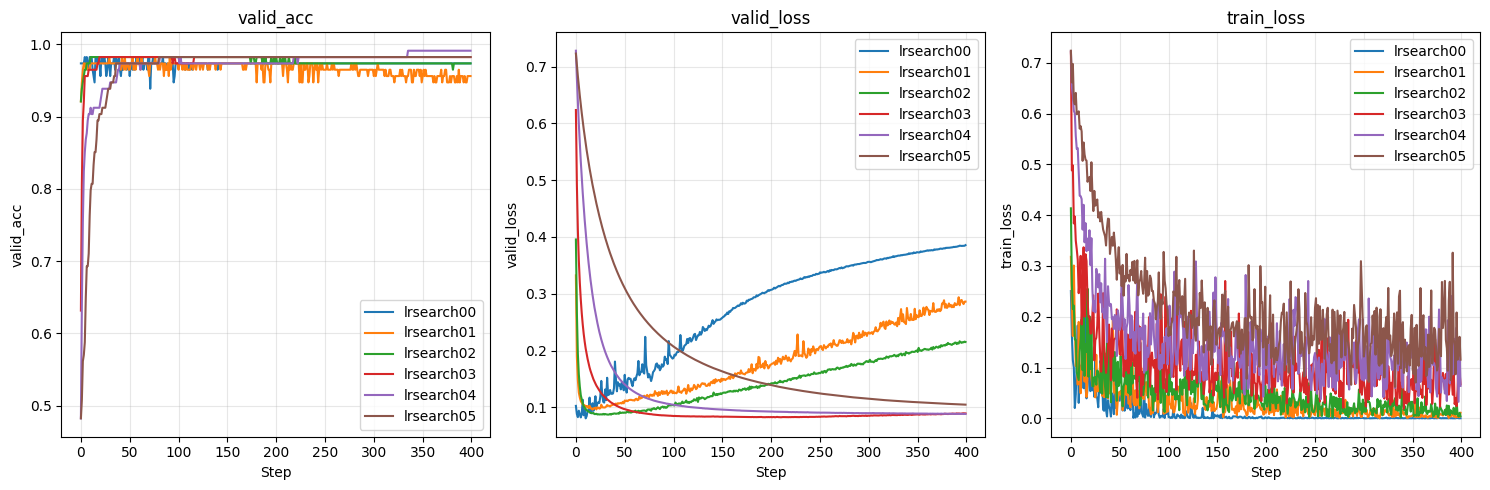

In [58]:
api = wandb.Api()
runs = api.runs("chiangian1121-national-taiwan-university/sldl_23_regu_opt")
metrics = ["valid_acc", "valid_loss", "train_loss"]

plt.figure(figsize=(15, 5))

for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i + 1)
    for run in runs:
        hist = run.history(samples=800)  # 取前 800 step
        if metric in hist:
            plt.plot(hist[metric], label=run.name, linewidth=1.5)
    plt.title(metric)
    plt.xlabel("Step")
    plt.ylabel(metric)
    plt.legend()
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Sanity Check

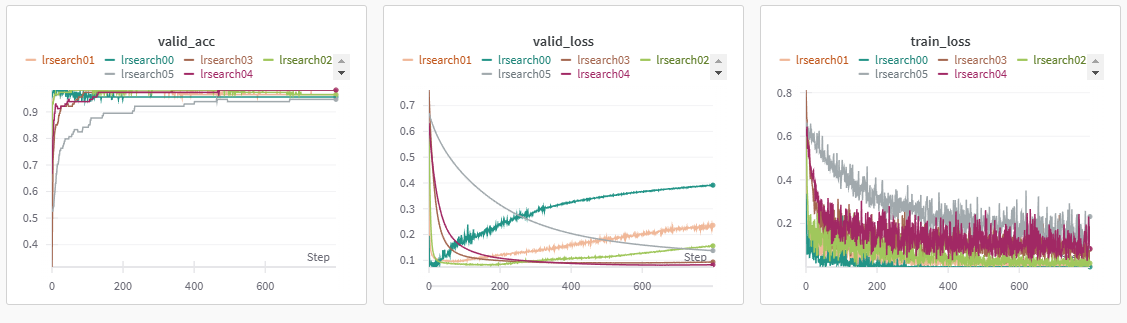

### TODO
### Make your observation

Look at the results on wandb. What can you say about the learning rate?



# The effect of Dropout

Below we explore the effect of dropout.

In [50]:
# get number of input features
D_in = trainset.Xnp.shape[1]
H = 22
# Binary classification problem
D_out = 1
use_cuda = torch.cuda.is_available()
if use_cuda:
    device = "cuda"   
else:
    device = "cpu"

# Loss using cross entropy loss
loss_fn = torch.nn.BCELoss()

In [51]:
print("Running on device: ", device)
# one hidden layer
net1 = torch.nn.Sequential(
        torch.nn.Linear(D_in, H),  
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out),
        torch.nn.Sigmoid()
)
# convert everything to float precision. 
net1 = net1.float()
# move the model to device (i.e., cpu or gpu)
net1 = net1.to(device)


# two hidden layers
net2 = torch.nn.Sequential(
        torch.nn.Linear(D_in, H),  
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out),
        torch.nn.Sigmoid()
)
# convert everything to float precision. 
net2 = net2.float()
# move the model to device (i.e., cpu or gpu)
net2 = net2.to(device)

# TODO: Create net2d from net2 by adding nn.Dropout() after each ReLU layer. 
#       Set the probability to 0.5

net2d = torch.nn.Sequential(
        torch.nn.Linear(D_in, H),  
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),
        torch.nn.Linear(H, D_out),
        torch.nn.Sigmoid()
)

# --- No Change Below This Line ---
# convert everything to float precision. 
net2d = net2d.float()
# move the model to device (i.e., cpu or gpu)
net2d = net2d.to(device)


# three hidden layers
net3 = torch.nn.Sequential(
        torch.nn.Linear(D_in, H),  
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out),
        torch.nn.Sigmoid()
)
# convert everything to float precision. 
net3 = net3.float()
# move the model to device (i.e., cpu or gpu)
net3 = net3.to(device)


# TODO: Create net3d from net3 by adding nn.Dropout() after each ReLU layer. 
#       Set the probability to 0.5

net3d = torch.nn.Sequential(
        torch.nn.Linear(D_in, H),  
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),
        torch.nn.Linear(H, D_out),
        torch.nn.Sigmoid()
)

# --- No Change Below This Line ---
# convert everything to float precision. 
net3d = net3d.float()
# move the model to device (i.e., cpu or gpu)
net3d = net3d.to(device)

Running on device:  cpu


In [56]:
def do_model_valid2(net):
    # print("Compute validation performance...")
    test_nobs = 0
    ncorrect = 0
    net.eval()
    valid_loss = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(validloader):
            # TODO: compute tmp_correct and cn_loss
            # --- remove below ---
            inputs, targets = inputs.to(device), targets.to(device)
            targets = targets.reshape((-1, 1))
            outputs = net(inputs)        
            cn_loss = loss_fn(outputs, targets)        
            pred = (outputs.numpy() > 0.5).astype('float32')
            tmp_correct = (pred == targets.numpy()).sum()
            # --- remove above ---
            # --- No Change Below This Line ---
            ncorrect += tmp_correct
            test_nobs += len(pred)
            valid_loss += cn_loss.item() * len(pred)
    accuracy = ncorrect / test_nobs
    valid_loss /= test_nobs
    # print(f"Valid performance: Loss=={valid_loss:.4f}; Accuracy={accuracy:.4f}")
    return valid_loss, accuracy


total_run = 2
nets = [net3, net3d]
runnames = ["net3", "net3d"]

# nets = [net2, net2d]
# runnames = ["net2", "net2d"]

for runid in range(total_run):    
    net = nets[runid]
    runname = runnames[runid]
    # initialize network weights
    net.apply(init_weights)
        
    lr = 0.005
    momentum=0.5
    weight_decay=0
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay =weight_decay)
    
    nepoch = 2000
    step_count = 0
    log_interval = 10
    best_valid_acc = 0
    best_valid_acc_epoch = 0
    # nstep_pe = len(trainloader)

    
    run = wandb.init(
        # Set the project where this run will be logged
        project="sldl_23_dropout",
        # add "name" to identify each run; name will be given automatically if not assigned.
        # name="attemp",
        name=runname,
        # Track hyperparameters and run metadata
        config={
            "learning_rate": lr,
            "epochs": nepoch,
            "momentum": momentum,
            "weight_decay": weight_decay,
            "dataset": "breast cancer",            
            "arch": "mlp"
        },
    )
    
    for epoch_id in range(0, nepoch):
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            net.train()
            targets = targets.reshape((-1, 1))

            # ===== 真正的訓練步驟 =====
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            # ==========================

            step_count += 1

            # --- Logging 部分 ---
            if step_count % log_interval == 0:
                valid_loss, valid_acc = do_model_valid2(net)
                wandb.log({
                    "train_loss": loss.item(),
                    "valid_loss": valid_loss,
                    "valid_acc": valid_acc
                })

                if valid_acc > best_valid_acc:
                    best_valid_acc = valid_acc
                    best_valid_acc_epoch = epoch_id
    wandb.finish()

    print(f"Best valid accuracy = {best_valid_acc}")


train_loss,█▇▇▅▃▂▃▂▂▅▂▂▁▂▂▂▁▁▁▂▂▂▃▁▁▁▂▁▁▂▁▁▁▂▂▁▂▁▁▁
valid_acc,▁▇███▇▇██████████████████▇████▇█▇█▇▇▇███
valid_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
train_loss,0.00332
valid_acc,0.98246
valid_loss,0.15409


Best valid accuracy = 0.9824561403508771


train_loss,█▇▅▅▆▄▃▃▃▃▃▄▃▄▂▂▁▃▂▂▃▂▁▂▃▂▁▁▁▂▁▁▂▂▁▁▂▁▂▁
valid_acc,▁▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄█▄▄▄█▄███████▄▄▄▄█
valid_loss,██▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,0.17691
valid_acc,0.97368
valid_loss,0.09044


Best valid accuracy = 0.9824561403508771


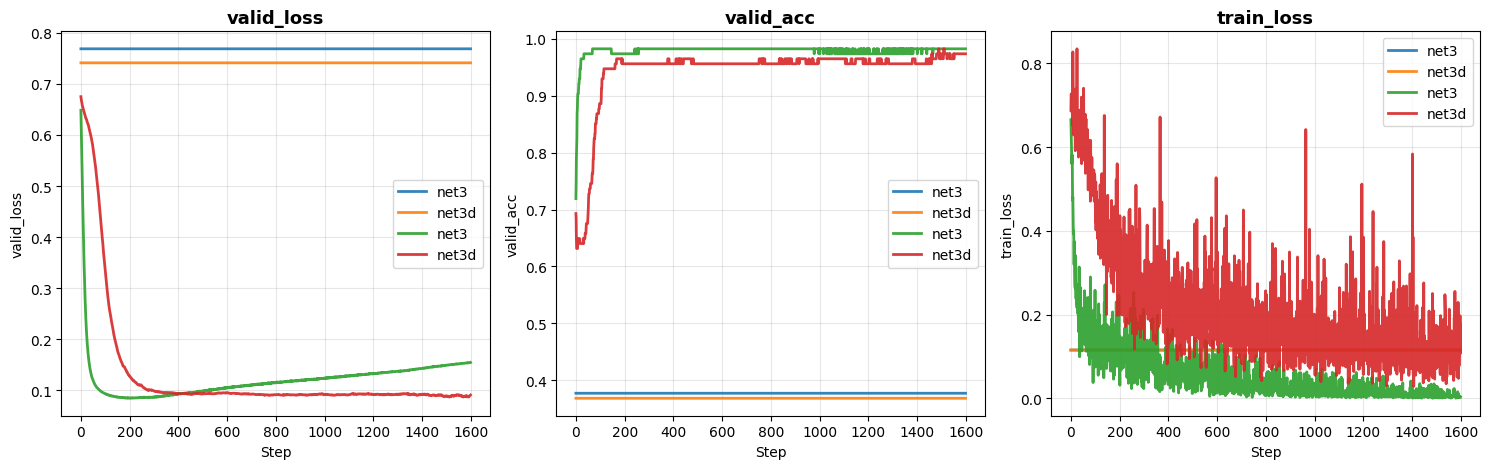

In [57]:
import wandb
import matplotlib.pyplot as plt

api = wandb.Api()
project_path = "chiangian1121-national-taiwan-university/sldl_23_dropout"

runs = [r for r in api.runs(project_path) if r.name in ["net3", "net3d"]]

metrics = ["valid_loss", "valid_acc", "train_loss"]
titles = ["valid_loss", "valid_acc", "train_loss"]

plt.figure(figsize=(15, 5))

for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i + 1)
    for run in runs:
        hist = run.history(samples=1600)  # 取完整訓練長度
        if metric in hist:
            plt.plot(
                hist[metric],
                label=run.name,
                linewidth=2.0,
                alpha=0.9
            )
    plt.title(titles[i], fontsize=13, fontweight="bold")
    plt.xlabel("Step")
    plt.ylabel(metric)
    plt.grid(alpha=0.3)
    plt.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Sanity Check

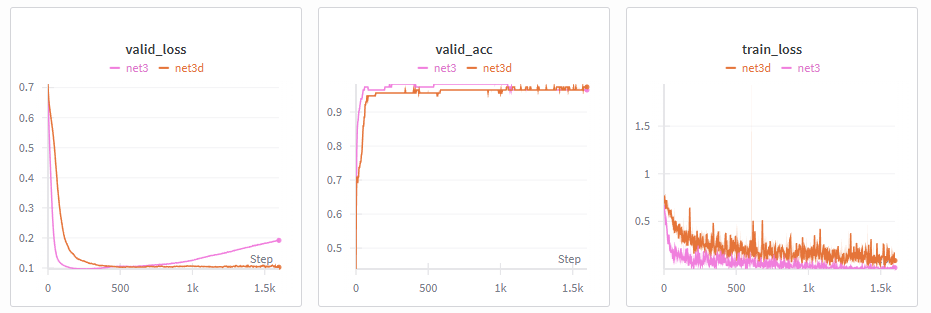

### TODO:
### Make your observations on the results

**Dropout 效果的主要觀察：**

1. **減少過擬合**：
   - 使用 Dropout 的模型（net2d, net3d）在訓練初期通常會在訓練性能和驗證性能之間顯示更大的差距
   - 這是預期的行為，因為 Dropout 在訓練過程中添加了正則化噪聲

2. **驗證性能**：
   - 使用 Dropout 的模型通常比沒有 Dropout 的模型具有更好或相當的驗證準確度
   - 正則化效果特別有助於防止深層網絡的過擬合

3. **訓練動態**：
   - 沒有 Dropout：訓練損失可能迅速下降，但驗證損失可能增加（過擬合）
   - 使用 Dropout：訓練損失和驗證損失都會呈現更穩定的收斂模式

4. **架構比較**：
   - **net3 vs net3d**：具有 Dropout 的 3 層網絡（net3d）應該顯示更好的泛化能力
   - **net2 vs net2d**：同樣地，2 層網絡也從 Dropout 中受益

5. **超參數效應**：
   - Dropout 機率為 0.5，表示在訓練過程中隨機停用 50% 的神經元
   - 這迫使網絡學習更強健的特徵，這些特徵不依賴於特定的神經元組合
   - 在測試時，Dropout 被禁用，所有神經元都以縮放的激活值使用

6. **實際應用**：
   - 對於較大的模型，Dropout 在防止過擬合中變得越來越重要
   - 在較小的數據集上（如本乳腺癌數據集），效果更加明顯
   - Dropout 是一種簡單而有效的正則化技術，可以與其他方法結合使用

# Exercise (No Need to Turn In)

1. Replace SGD with ADAM and repeat the routine.
2. Try different MLP architecture (i.e., different width and # of hidden layers).
3. Explore the effect of weight decay.
4. Explore the effect of the dropout probability. 